In [1]:
using Plots, SparseArrays, LinearAlgebra, Krylov, Revise
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")
includet("MG_preconditioner.jl")

In [2]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[160,150] = n^2
f = vec(f);
σ = -10000* ones(length(grid),length(grid))
σ = complex(σ) 


# existing outer walls
σ[64:192, 64] .= -50000*(1.2+0.2im)
σ[64:192, 192] .= -50000*(1.2+0.2im)
σ[64, 64:192] .= -50000*(1.2+0.2im)
σ[192, 64:192] .= -50000*(1.2+0.2im)

# modified inner walls to create rooms
σ[64:192, 128] .= -50000*(1.2+0.2im)  # vertical wall
σ[128, 64:192] .= -50000*(1.2+0.2im)  # horizontal wall

# bigger doors on outer walls
σ[90:110, 64] .= -10000  # door on the left wall
σ[90:110, 192] .= -10000  # door on the right wall
σ[64, 90:110] .= -10000  # door on the top wall
σ[192, 90:110] .= -10000  # door on the bottom wall

# doors on inner walls
σ[90:110, 128] .= -10000  # door on the vertical inner wall
σ[128, 90:110] .= -10000  # door on the horizontal inner wall

# door for the closed room
σ[150:160, 128] .= -10000  # door on the vertical inner wall

complex_shift = (1+im)
σ_shifted = σ*complex_shift
sigmas = spdiagm(vec(σ))
sigmas_shifted = spdiagm(vec(σ_shifted))
H = helmholtz2D(grid,sigmas);
H_shifted = helmholtz2D(grid,sigmas_shifted);
pre = nonuniform_preconditioner(; grid=grid, H=H_shifted, nu1=3,nu2=3)

myPreconditioner(var"#pres#23"{Vector{ComplexF64}, SparseMatrixCSC{ComplexF64, Int64}, Int64, Int64}(ComplexF64[-0.4921875 - 0.2841645856167689im, -0.484375 - 0.27965403663872496im, -0.4765625 - 0.275143487660681im, -0.46875 - 0.27063293868263705im, -0.4609375 - 0.26612238970459307im, -0.453125 - 0.26161184072654914im, -0.4453125 - 0.25710129174850516im, -0.4375 - 0.25259074277046123im, -0.4296875 - 0.2480801937924173im, -0.421875 - 0.24356964481437335im  …  1.421875 + 0.24356964481437335im, 1.4296875 + 0.2480801937924173im, 1.4375 + 0.25259074277046123im, 1.4453125 + 0.25710129174850516im, 1.453125 + 0.26161184072654914im, 1.4609375 + 0.26612238970459307im, 1.46875 + 0.27063293868263705im, 1.4765625 + 0.275143487660681im, 1.484375 + 0.27965403663872496im, 1.4921875 + 0.2841645856167689im], sparse([1, 2, 256, 1, 2, 3, 257, 2, 3, 4  …  65022, 65023, 65024, 64769, 65023, 65024, 65025, 64770, 65024, 65025], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 

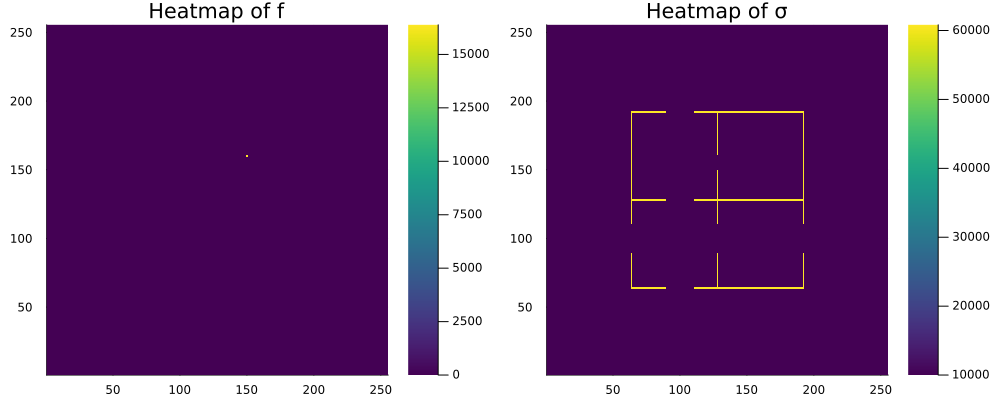

In [3]:
p1 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p2 = heatmap(reshape(abs.(σ),length(grid),length(grid)), color=:viridis, title="Heatmap of σ")

plot(p1, p2, layout = (1, 2), size = (1000, 400))

In [4]:
sol = H\f;

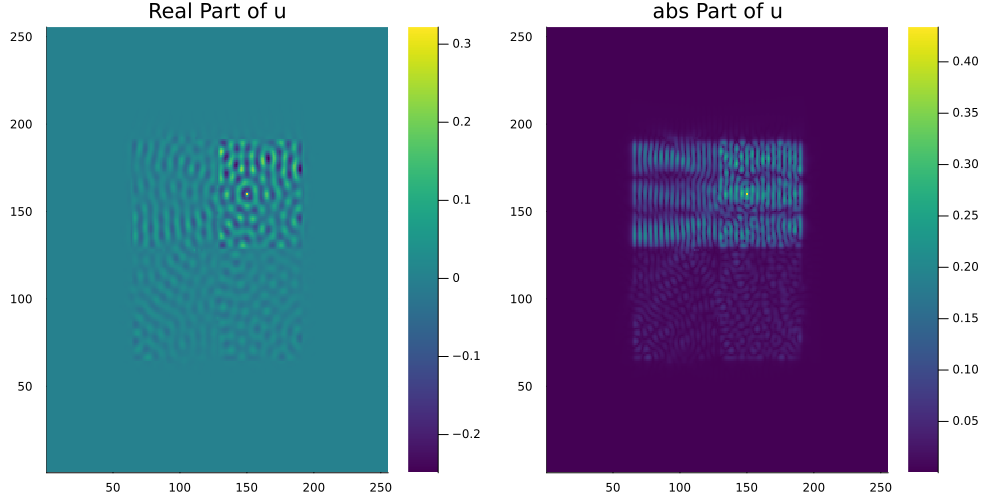

In [5]:
theme(:default)
z = reshape(sol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(abs.(z), color=:viridis, title="abs Part of u")

plot(p1, p2, layout = (1, 2), size = (1000, 500))

In [6]:
S = Krylov.ktypeof(complex(float(f)))
global X = S[]  # Storage for GMRES iterates
gmres_callback(solver) = gmres_callbackX!(X,solver)

gmres_callback (generic function with 1 method)

In [10]:
X = S[]
presol, prestats = gmres(H, complex(float(f)), 
M=pre,
ldiv =false,
itmax = 500 ,
memory=500,
restart =true,
history=true,
callback =gmres_callback);
preres = [norm(H *x-f) for x in X];

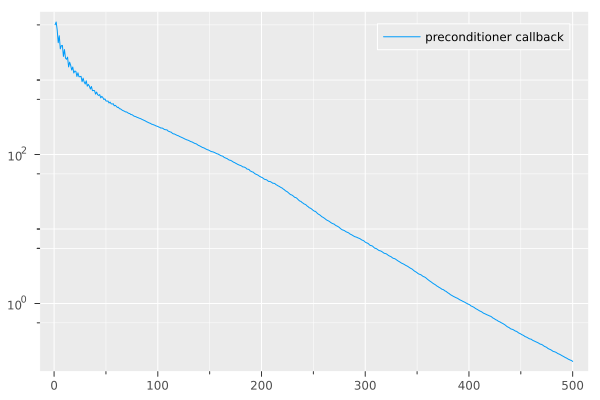

In [11]:
theme(:ggplot2)
plot(preres, yscale =:log10, label="preconditioner callback")

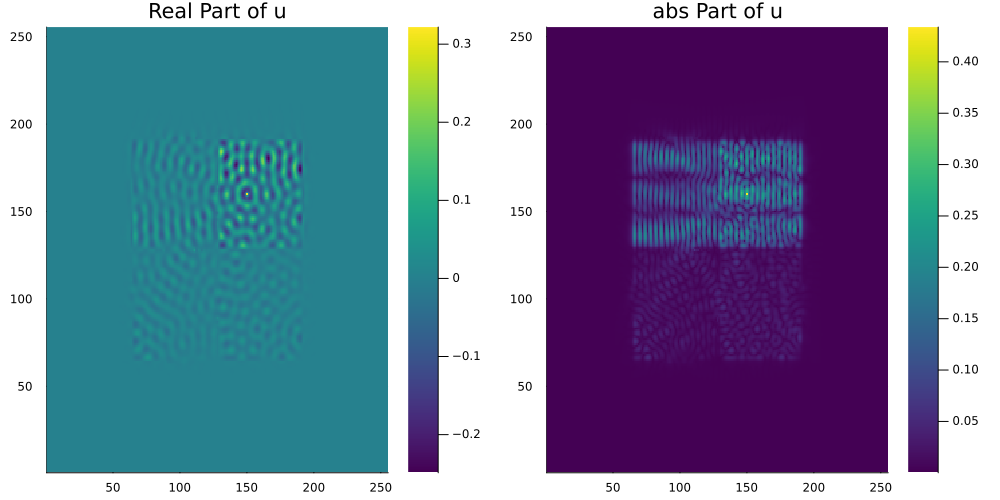

In [12]:
theme(:default)
z = reshape(presol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(abs.(z), color=:viridis, title="abs Part of u")

plot(p1, p2, layout = (1, 2), size = (1000, 500))